In [22]:
import pandas as pd

def prepareData(df):
    df['start_date'] = pd.to_datetime(df['start_date'])
    
    df['weekday'] = df['start_date'].dt.dayofweek
    df['hour'] = df['start_date'].dt.hour
    df['num_week'] = df['start_date'].dt.isocalendar().week
    df = df.drop(['start_date','start_station_code', 'end_date', 'end_station_code', 'duration_sec', 'is_member', 'Temperature_C'], axis=1)
    
    # Group by hour
    df_agrupado = df.groupby(['num_week','weekday', 'hour']).agg('first')
    columna = df.groupby(['num_week','weekday', 'hour']).count()['Description']
    
    df_agrupado['num_trips']= columna
    df_agrupado=df_agrupado.reset_index(level=[0,1,2])
    
    return df_agrupado

In [23]:
OD_2014_weather_agg = pd.read_csv('/Users/sayems_mac/BixiMatch/data/OD/OD_2014_weather.csv')
OD_2015_weather_agg = pd.read_csv('/Users/sayems_mac/BixiMatch/data/OD/OD_2015_weather.csv')
OD_2016_weather_agg = pd.read_csv('/Users/sayems_mac/BixiMatch/data/OD/OD_2016_weather.csv')
OD_2017_weather_agg = pd.read_csv('/Users/sayems_mac/BixiMatch/data/OD/OD_2017_weather.csv')

OD_2017_weather_agg.head()

,start_date,start_station_code,end_date,end_station_code,duration_sec,is_member,Description,Temperature,Pressure,Wind_speed,Temperature_C
0,2017-04-15 00:00:00,7060,2017-04-15 00:31:00,7060,1841,1,few clouds,286.15,1027.0,4.0,13.00
1,2017-04-15 01:00:00,6007,2017-04-15 01:20:00,6127,1227,1,few clouds,283.82,1027.0,3.0,10.67
2,2017-04-15 01:00:00,6395,2017-04-15 01:09:00,6076,516,1,few clouds,283.82,1027.0,3.0,10.67
3,2017-04-15 01:00:00,6213,2017-04-15 01:08:00,6203,470,1,few clouds,283.82,1027.0,3.0,10.67
4,2017-04-15 01:00:00,6026,2017-04-15 01:31:00,6041,1849,1,few clouds,283.82,1027.0,3.0,10.67


In [24]:
OD_2017_weather_agg = prepareData(OD_2017_weather_agg);
OD_2017_weather_agg.tail()

,num_week,weekday,hour,Description,Temperature,Pressure,Wind_speed,num_trips
4773,46,2,19,few clouds,278.80,1022.0,4.0,10
4774,46,2,20,scattered clouds,279.15,1021.0,5.0,4
4775,46,2,21,scattered clouds,279.15,1020.0,6.0,13
4776,46,2,22,broken clouds,277.47,1020.0,5.0,6
4777,46,2,23,broken clouds,276.47,1020.0,2.0,2


In [25]:
OD_2014_weather_agg = prepareData(OD_2014_weather_agg);
OD_2015_weather_agg = prepareData(OD_2015_weather_agg);
OD_2016_weather_agg = prepareData(OD_2016_weather_agg);

OD_2014_weather_agg.head()

,num_week,weekday,hour,Description,Temperature,Pressure,Wind_speed,num_trips
0,16,1,3,light rain,288.05,1003.0,5.0,1
1,16,1,6,light rain,287.31,1003.0,3.0,2
2,16,1,8,light rain,286.64,1002.0,3.0,4
3,16,1,9,light rain,286.74,1002.0,3.0,6
4,16,1,11,overcast clouds,287.70,997.0,9.0,1


In [27]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(list(OD_2017_weather_agg['Description']) + list(OD_2016_weather_agg['Description']) + list(OD_2015_weather_agg['Description']) + list(OD_2014_weather_agg['Description']))

OD_2014_weather_agg['Description'] = le.transform(OD_2014_weather_agg['Description'])
OD_2015_weather_agg['Description'] = le.transform(OD_2015_weather_agg['Description'])
OD_2016_weather_agg['Description'] = le.transform(OD_2016_weather_agg['Description'])
OD_2017_weather_agg['Description'] = le.transform(OD_2017_weather_agg['Description'])

In [28]:
import numpy as np

Xtst = []
ytst = []

Ntst = OD_2017_weather_agg.shape[0]

ahead = 24 #24 hours forecast
for k in range(720,Ntst-24):
    Xtst.append(np.hstack((
                OD_2017_weather_agg['num_trips'].values[k-720:k-1],           # last month usage
                OD_2017_weather_agg['Description'].values[k-24:k+24],    
                OD_2017_weather_agg['Temperature'].values[k-24:k+24],   
                OD_2017_weather_agg['Wind_speed'].values[k-24:k+24],
                OD_2017_weather_agg['num_week'].values[k],              
                OD_2017_weather_agg['weekday'].values[k],                 
                OD_2017_weather_agg['hour'].values[k],               
                1                     
            )).tolist()  )
    ytst.append(OD_2017_weather_agg['num_trips'].values[k+ahead].tolist() )

Xtst = np.array(Xtst)
ytst = np.array(ytst)

In [29]:
X = []
y = []

for datos_entrenamiento in [OD_2014_weather_agg, OD_2015_weather_agg, OD_2016_weather_agg]:
    for k in range(720, datos_entrenamiento.shape[0] - 24):
        X.append(np.hstack((
                    datos_entrenamiento['num_trips'].values[k-720:k-1],           
                    datos_entrenamiento['Description'].values[k-24:k+24],  
                    datos_entrenamiento['Temperature'].values[k-24:k+24],  
                    datos_entrenamiento['Wind_speed'].values[k-24:k+24], 
                    datos_entrenamiento['num_week'].values[k],             
                    datos_entrenamiento['weekday'].values[k],               
                    datos_entrenamiento['hour'].values[k],            
                    1                      
                )).tolist()  )
        y.append(datos_entrenamiento['num_trips'].values[k+ahead].tolist() );

X = np.array(X)
y = np.array(y)

In [30]:
from sklearn.preprocessing import MinMaxScaler

minmaxx = MinMaxScaler(feature_range=(0,1));
minmaxx.fit(Xtst);

X_norm    = minmaxx.transform(X);
Xtst_norm = minmaxx.transform(Xtst);

minmaxy = MinMaxScaler(feature_range=(0,1));
minmaxy.fit(ytst.reshape(-1, 1));

y_norm    = minmaxy.transform(y.reshape(-1, 1));
ytst_norm = minmaxy.transform(ytst.reshape(-1, 1));

In [49]:
# Debugging: Check feature consistency
print("Training features:", X.shape)
print("Test features:", Xtst.shape)


Training features: (11718, 867)
Test features: (4034, 867)


In [31]:
%%time
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

clf = linear_model.Ridge (alpha = 1);
clf.fit(X_norm,y_norm);
yest_norm = clf.predict(Xtst_norm);
print("Mean squared error: %f" % (mean_squared_error(ytst_norm, yest_norm)));

Mean squared error: 0.020581
CPU times: user 760 ms, sys: 87.2 ms, total: 847 ms
Wall time: 210 ms


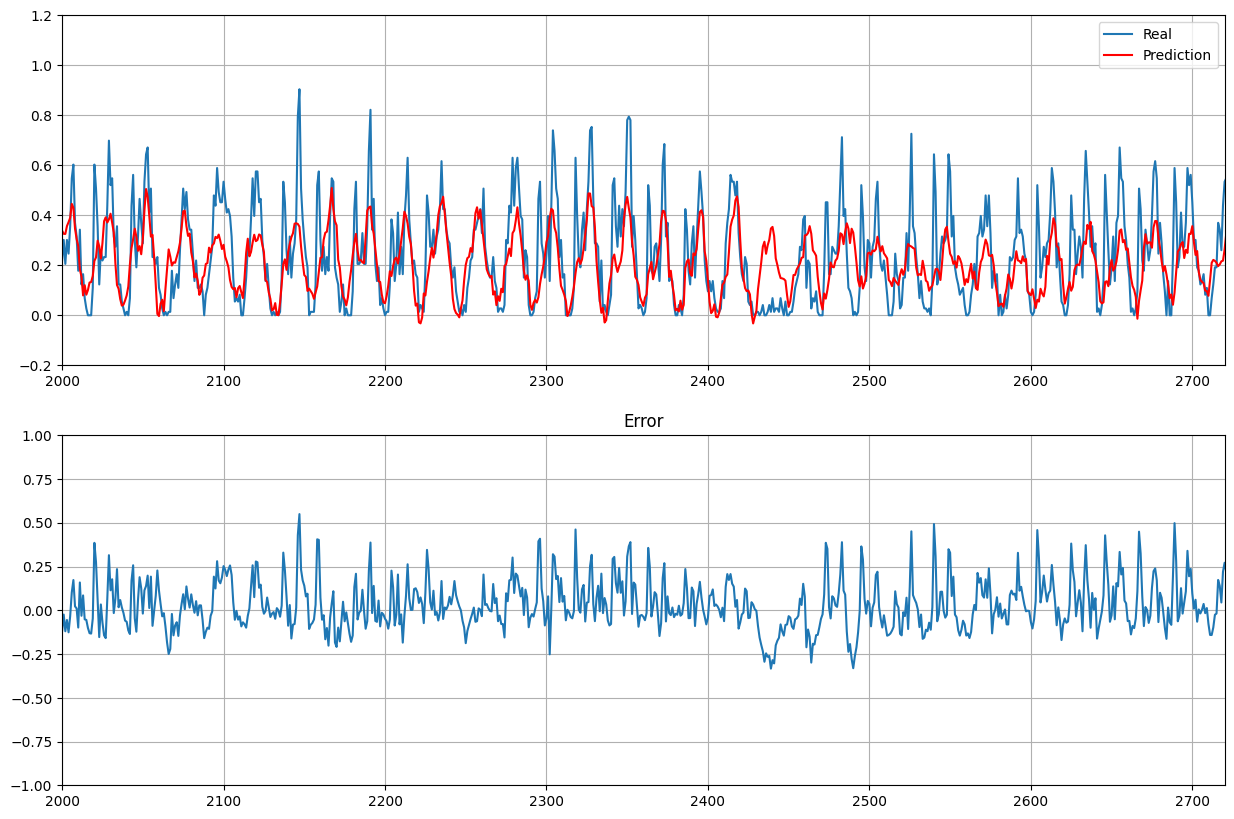

In [32]:
import matplotlib.pyplot as plt

plt.figure(1,figsize=(15,10));
plt.subplot(2,1,1);
plt.plot(ytst_norm);
plt.plot(yest_norm,'r');
plt.grid('on');
plt.legend(['Real',u'Prediction']);
plt.axis(xmin=2000,xmax=2720,ymin=-.2,ymax=1.2);

plt.subplot(2,1,2);
plt.plot(ytst_norm-yest_norm);
plt.title('Error');
plt.axis(ymin=-1,ymax=1);
plt.grid('on');
plt.axis(xmin=2000,xmax=2720,ymin=-1,ymax=1);

In [34]:
# Save the model

import pickle

filename = 'linear_model.sav'
pickle.dump(clf, open(filename, 'wb'))


0.3831430161397109
